# IMERG
<!-- markdownlint-disable MD013 -->

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import ocha_stratus as stratus

from src.datasources import imerg, ibtracs, zma
from src.constants import *

## Load IMERG

In [3]:
pcode = "CU"

In [4]:
%%time
# load all IMERG data - bit slow
df_imerg = imerg.load_imerg(pcode)

CPU times: user 125 ms, sys: 27.9 ms, total: 153 ms
Wall time: 6.16 s


In [5]:
df_imerg["valid_date"] = pd.to_datetime(df_imerg["valid_date"])

<Axes: >

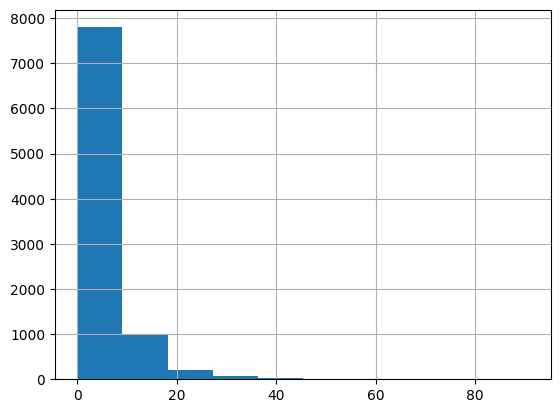

In [6]:
df_imerg["mean"].hist()

In [7]:
df_imerg["roll2_mean"] = df_imerg["mean"].rolling(2).sum()

Just get a general idea of yearly peak values

In [8]:
df_imerg.groupby(df_imerg["valid_date"].dt.year)[
    "roll2_mean"
].max().reset_index().sort_values("roll2_mean", ascending=False)

,valid_date,roll2_mean
10,2010,125.514080
1,2001,120.507424
8,2008,114.313233
20,2020,112.243160
2,2002,111.557137
18,2018,108.781929
23,2023,99.384370
5,2005,97.973385
11,2011,97.300541
7,2007,95.026070


In [9]:
df_imerg

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,roll2_mean
0,CUB,CU,2000-06-04,0,6.914716,3.870000,0.0,59.784996,3791,26213.690,7.977752,NaN
1,CUB,CU,2000-06-05,0,10.971368,6.254999,0.0,95.700000,3791,41592.453,12.472013,17.886084
2,CUB,CU,2000-06-06,0,6.899565,4.270000,0.0,39.845000,3791,26156.250,7.358684,17.870933
3,CUB,CU,2000-06-07,0,2.988547,0.915000,0.0,38.565000,3791,11329.580,4.963941,9.888111
4,CUB,CU,2000-06-08,0,4.753370,3.015000,0.0,34.489998,3791,18020.025,5.450318,7.741917
...,...,...,...,...,...,...,...,...,...,...,...,...
9103,CUB,CU,2025-04-28,0,1.490862,0.000000,0.0,67.965000,3791,5651.860,4.765209,6.227740
9104,CUB,CU,2025-05-01,0,0.573351,0.000000,0.0,34.510000,3791,2173.575,2.060242,2.064214
9105,CUB,CU,2025-05-05,0,6.518980,0.995000,0.0,79.415000,3791,24713.455,10.494596,7.092332
9106,CUB,CU,2025-05-06,0,3.942065,0.605000,0.0,78.469986,3791,14944.369,8.655358,10.461046


## Process rainfall
### Load storms

In [11]:
gdf_zma = zma.load_zma()

In [12]:
df_all = ibtracs.load_ibtracs_in_bounds(*gdf_zma.total_bounds)

In [15]:
df_agg = (
    df_all.groupby("sid")
    .agg(
        valid_time_min=("valid_time", "min"),
        valid_time_max=("valid_time", "max"),
        wind_speed_max=("wind_speed", "max"),
    )
    .reset_index()
)

### Get rainfall per storm 

Relatively simplistic - look at the dates the storm was in the ZMI, and take the 2-day rolling sum of rainfall over the whole country (this is what is used as a trigger in Haiti, so could be a good starting point). We include one day on either side of the time the storm is in the ZMI.

In [16]:
def get_storm_rainfall(storm_row):
    min_date = storm_row["valid_time_min"].date()
    max_date = storm_row["valid_time_max"].date() + pd.DateOffset(days=1)
    dff_imerg = df_imerg[
        (df_imerg["valid_date"] >= pd.Timestamp(min_date))
        & (df_imerg["valid_date"] <= pd.Timestamp(max_date))
    ]
    storm_row["max_roll2_mean"] = dff_imerg["roll2_mean"].max()
    return storm_row

In [17]:
df_agg = df_agg.apply(get_storm_rainfall, axis=1)

In [18]:
df_agg

,sid,valid_time_min,valid_time_max,wind_speed_max,max_roll2_mean
0,2023152N26274,2023-06-03 18:00:00.000039,2023-06-04 06:00:00.000039,25.0,53.528820
1,2023239N21274,2023-08-26 12:00:00.000039,2023-08-29 12:00:00.000039,70.0,33.697277
2,2023321N15278,2023-11-17 21:00:00.000039,2023-11-18 00:00:00.000039,30.0,41.093265


In [19]:
blob_name = f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats.parquet"

In [20]:
stratus.upload_parquet_to_blob(df_agg, blob_name)